# 01 — Data Exploration

This notebook performs:
- Raw data loading
- Date cleaning and sorting
- Duplicate & missing day checks
- Basic price visualization

No modeling logic is implemented here.


In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import pandas as pd
import matplotlib.pyplot as plt

from src.data_loader import load_data


In [3]:
df = load_data("../data/bharti_airtel_futures_2021_2024.csv",filter_expiry=[2])
df = df[df["expiry_rank"].isin([2])].reset_index(drop=True)
df.head()


,Date,Expiry Date,Option Type,Strike Price,Open Price,High Price,Low Price,Close Price,Last Price,Settlement Price,Volume,Value (₹ Lakhs),Premium Value (₹ Lakhs),Open Interest,Change in OI,source_file,CLOSE,number_of_days_to_expiry,expiry_rank
0,2021-01-01,2021-02-25,XX,-,513.85,521.05,512.55,520.10,520.65,520.10,438687.0,"22,66,14,135.45","22,66,14,135.45",1229064.0,25914.0,Quote-Derivative-BHARTIARTL-01-01-2021-31-12-2...,520.10,55,2
1,2021-01-04,2021-02-25,XX,-,521.05,524.05,515.35,521.05,520.85,521.05,732996.0,"38,11,88,739.15","38,11,88,739.15",1282743.0,53679.0,Quote-Derivative-BHARTIARTL-01-01-2021-31-12-2...,521.05,52,2
2,2021-01-05,2021-02-25,XX,-,515.10,521.15,514.60,518.80,518.50,518.80,649701.0,"33,70,36,928.70","33,70,36,928.70",1369740.0,86997.0,Quote-Derivative-BHARTIARTL-01-01-2021-31-12-2...,518.80,51,2
3,2021-01-06,2021-02-25,XX,-,517.10,536.50,517.10,530.85,533.55,530.85,1615923.0,"85,53,11,931.00","85,53,11,931.00",1192044.0,-177696.0,Quote-Derivative-BHARTIARTL-01-01-2021-31-12-2...,530.85,50,2
4,2021-01-07,2021-02-25,XX,-,533.65,558.45,531.65,549.40,548.50,549.40,2807967.0,"1,53,92,34,681.75","1,53,92,34,681.75",1721430.0,529386.0,Quote-Derivative-BHARTIARTL-01-01-2021-31-12-2...,549.40,49,2


In [4]:
print("Rows:", len(df))
print("Duplicate dates:", df["Date"].duplicated().sum())


Rows: 990
Duplicate dates: 0


In [5]:
from src.data_loader import correlation_analysis
corr_price, corr_return = correlation_analysis(df)

print("Correlation with LOG PRICE")
print(corr_price)

print("\nCorrelation with LOG RETURN")
print(corr_return)

Correlation with LOG PRICE
Settlement Price            0.995834
Close Price                 0.995834
Last Price                  0.995755
High Price                  0.995496
Low Price                   0.994209
Open Price                  0.993192
number_of_days_to_expiry    0.011790
Change in OI               -0.205847
Open Interest              -0.216414
Volume                     -0.224307
dtype: float64

Correlation with LOG RETURN
number_of_days_to_expiry    0.069153
Last Price                  0.043752
Settlement Price            0.043214
Close Price                 0.043214
High Price                  0.016301
Low Price                   0.009550
Open Price                 -0.024378
Volume                     -0.042188
Change in OI               -0.049484
Open Interest              -0.066285
dtype: float64


In [6]:
# Missing business days (approximate check)
expected = pd.date_range(
    start=min(df["Date"]),
    end=max(df["Date"]),
    freq="B"
)

missing_days = expected.difference(pd.to_datetime(df["Date"]))
print("Missing trading days:", len(missing_days))


Missing trading days: 57


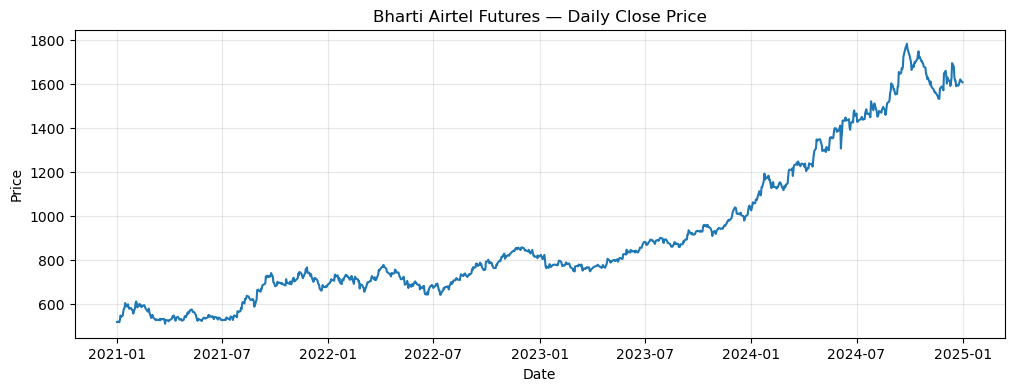

In [7]:
plt.figure(figsize=(12,4))
plt.plot(df["Date"], df["CLOSE"])
plt.title("Bharti Airtel Futures — Daily Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.show()


In [10]:
import numpy as np
df["log_return"] = np.log(df["CLOSE"] / df["CLOSE"].shift(1))
df = df.dropna().reset_index(drop=True)

df[["Date", "log_return"]].head()

,Date,log_return
0,2021-01-05,-0.004328
1,2021-01-06,0.022961
2,2021-01-07,0.034347
3,2021-01-08,-0.011625
4,2021-01-11,0.011625


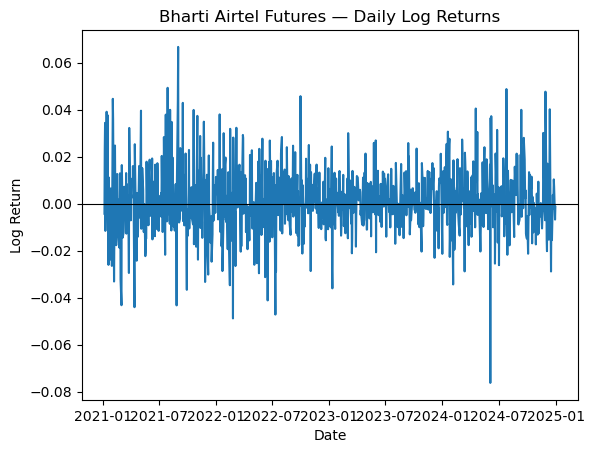

In [12]:
plt.plot(df["Date"], df["log_return"])
plt.title("Bharti Airtel Futures — Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.axhline(0, color="black", linewidth=0.8)
plt.show()

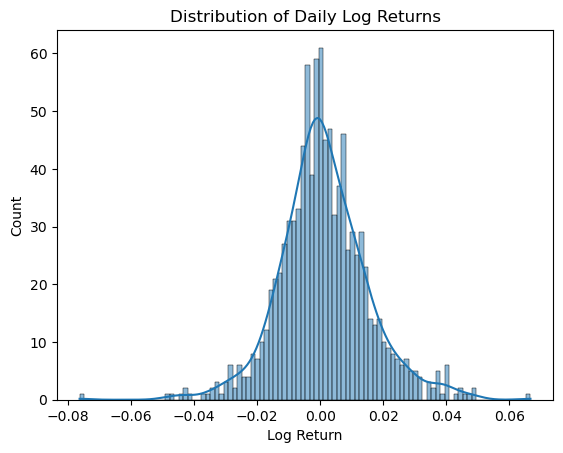

count    988.000000
mean       0.001141
std        0.014223
min       -0.076328
25%       -0.006777
50%        0.000160
75%        0.008697
max        0.066676
Name: log_return, dtype: float64


In [14]:

import seaborn as sns
sns.histplot(df["log_return"], bins=100, kde=True)
plt.title("Distribution of Daily Log Returns")
plt.xlabel("Log Return")
plt.show()

print(df["log_return"].describe())

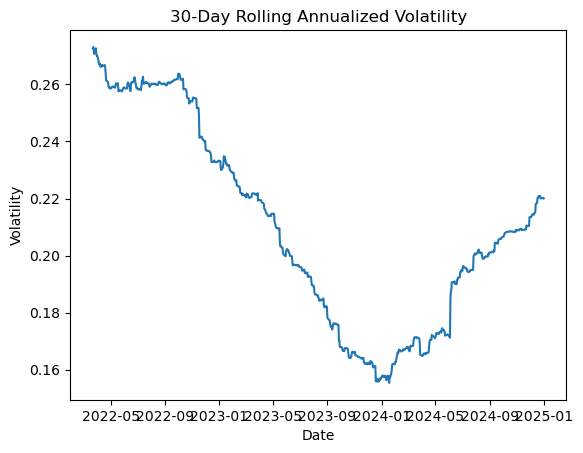

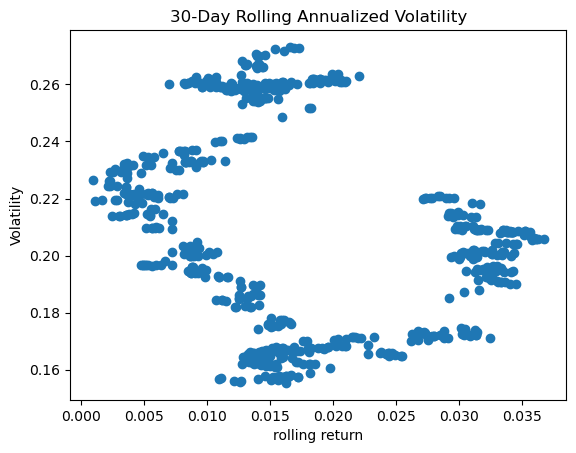

In [29]:
rolling_vol = df["log_return"].rolling(300).std() * np.sqrt(252)
rolling_mean = df["log_return"].rolling(300).mean() * np.sqrt(252)

plt.plot(df["Date"], rolling_vol)
plt.title("30-Day Rolling Annualized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()
plt.scatter(rolling_mean, rolling_vol)
plt.title("30-Day Rolling Annualized Volatility")
plt.xlabel("rolling return")
plt.ylabel("Volatility")
plt.show()

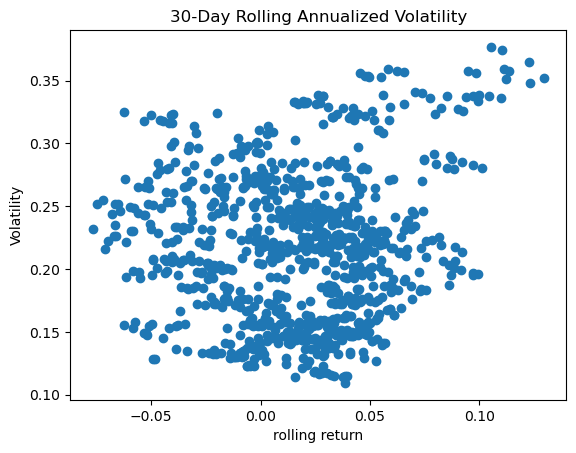

In [27]:

plt.scatter(rolling_mean, rolling_vol)
plt.title("30-Day Rolling Annualized Volatility")
plt.xlabel("rolling return")
plt.ylabel("Volatility")
plt.show()

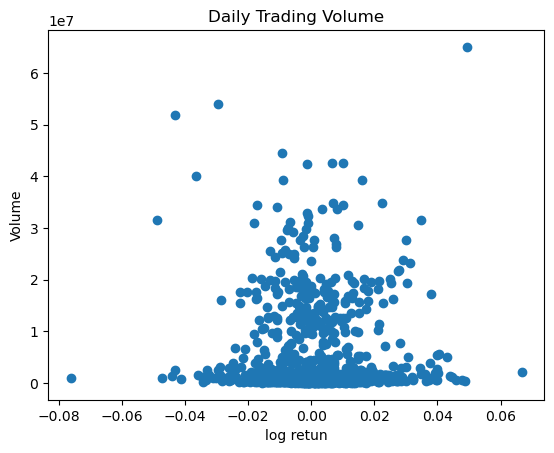

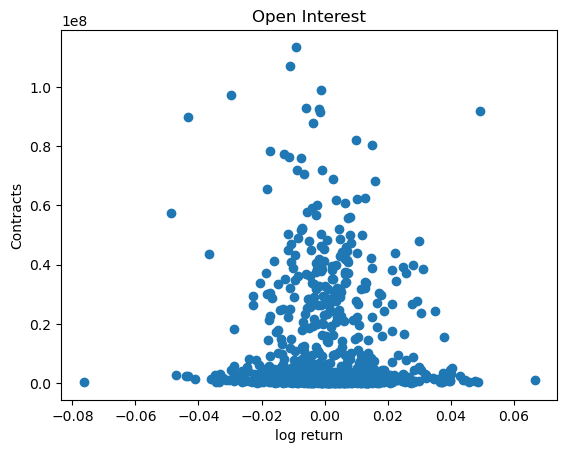

In [24]:
if "Volume" in df.columns:
    plt.scatter(df["log_return"], df["Volume"])
    plt.title("Daily Trading Volume")
    plt.xlabel("log retun")
    plt.ylabel("Volume")
    plt.show()

if "Open Interest" in df.columns:
    plt.scatter(df["log_return"], df["Open Interest"])
    plt.title("Open Interest")
    plt.xlabel("log return")
    plt.ylabel("Contracts")
    plt.show()